# Package Importation

In [ ]:
#Data manipulation and visulisation
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd 
import numpy as np 


#Image loading and processing
from keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.image import ImageDataGenerator


#Data Processing for modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical


#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


#Sklearn Classification models
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

#Keras Modelling for CNNs
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import regularizers, optimizers


#OS package
import os

# Data Importation

In this section unzip the tar.bz2 file containing the data required for this project. The first of the two key parts of data for this project are the 'hasy-data-labels.csv'file which contains the images paths for all of the images and their associated labels. The second is the directory called 'hasy-data' and contains the 168233 images of the mathematical characters and symbols. Once the csv is imported as a dataframe we will look to load the desired images(the greek letters) and convert them to arrays ready for modelling.

In [ ]:
#Extract contents of tar.bz2 file containing the dataset
!tar -xjvf "HASYv2.tar.bz2"

In [ ]:
#Import dataframe containing the labels for each image and their image paths
labelled_df = pd.read_csv('hasy-data-labels.csv')

In [ ]:
#Changes directory so we are in the directory containing the images and checks the number of photos in the folder
#to ensure that the unzipping has gone correctly. There should be 168233 items in the folder. We then return to the parent directory.
os.chdir('hasy-data')
print(len(os.listdir()))
os.chdir('..')

168233


## Initial Exploration

Exploring the dataframe, checking dtypes, unique values and creating a dataframe consisting of only the greek letters in this dataset.

In [ ]:
#Manual inspection of dataframe 
labelled_df.head(5)

,path,symbol_id,latex,user_id
0,hasy-data/v2-00000.png,31,A,50
1,hasy-data/v2-00001.png,31,A,10
2,hasy-data/v2-00002.png,31,A,43
3,hasy-data/v2-00003.png,31,A,43
4,hasy-data/v2-00004.png,31,A,4435


In [ ]:
#Double check size and shape of dataframe
labelled_df.shape

(168233, 4)

In [ ]:
#Check dataframe datatypes
labelled_df.dtypes

path         object
symbol_id     int64
latex        object
user_id       int64
dtype: object

In [ ]:
#Finds the unique letters/symbols contained in the dataset - Note that there are 369 unique different mathematical symbols/characters
labelled_df['latex'].unique()

In [ ]:
#Since I will only be looking at the greek letters I have created a list containing all of the 
#greek letters in order(lower case first then upper case and then alternative styles)
greek_letters = ['\\alpha','\\beta','\\gamma','\\delta','\\epsilon','\\zeta','\\eta','\\theta','\\iota',
                 '\\kappa','\\lambda','\\mu','\\nu','\\xi','\\pi','\\rho','\\sigma','\\tau',
                 '\\phi','\\chi','\\psi','\\omega','\\Gamma', '\\Delta','\\Theta','\\Lambda','\\Xi','\\Pi',
                 '\\Sigma','\\Phi','\\Psi','\\Omega','\\varepsilon','\\varkappa','\\varpi','\\varrho','\\varphi','\\vartheta']

In [ ]:
#Create a list of ints from 0 to 37 (38 integers) that I will assign to each unique greek letter and this is what I will use to identify them
greek_encoding = [i for i in range(38)]

In [ ]:
#From the whole dataframe I create a new dataframe consisting only of the greek letters
greek_letters_df = labelled_df[labelled_df['latex'].isin(greek_letters)]

In [ ]:
#With the list of greek letters and their encoding I create a dictionary so that I can assign the images their correct encoded value
greek_dict = dict(zip(greek_letters, greek_encoding))

In [ ]:
#Creates a new column in the dataframe which adds the greek letter's encoded value - the label
greek_letters_df['label'] = greek_letters_df['latex'].apply(lambda x: greek_dict.get(x))

## Class imbalance

Before I begin loading in the images I will firstly look at the class imbalance within the dataset and create a barchart visualisaing this imbalance.

In [ ]:
#Counts the number of times each greek letter appears, in descending order of count
greek_letter_count = greek_letters_df.groupby(by = 'latex')['label'].count().reset_index(name= 'count').sort_values(['count'],ascending = False)

In [ ]:
#Creates a list of the greek letters in the same order as the groupby above and formats them so that they will be in latex in the barplot as these will 
# be the labels of the bars
latex_labels = [r'$' + x + '$' for x in greek_letter_count['latex']]

Text(0, 0.5, 'Image Count')

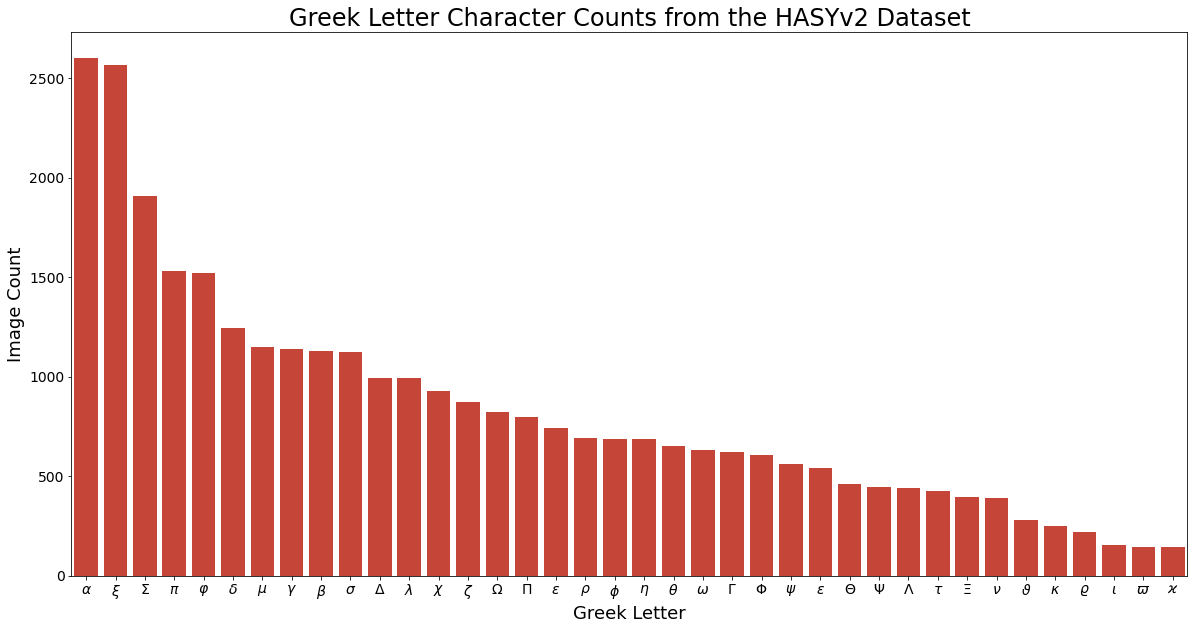

In [ ]:
#Creates a barchart of the number of times each greek letter occurs in the dataset

greek_letter_count_plot = plt.figure(figsize = (20,10))


sns.barplot(data = greek_letter_count,y = 'count',x = 'latex',color = '#DC3220')
plt.title('Greek Letter Character Counts from the HASYv2 Dataset',fontsize = 24)
plt.xticks(greek_encoding,labels = latex_labels, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Greek Letter',fontsize = 18)
plt.ylabel('Image Count',fontsize = 18)


## Data Preparation

In this section I will be importing the images and converting them into arrays. Additionally, I will be formatting the arrays into a suitable format for the upcoming modelling techniques. Note that at the end of this workbook I will provide an alternative approach to loading in image data using Keras ImageDataGenerators.





In [ ]:
#Creates a list of image paths
greek_letter_img_paths = greek_letters_df['path'].tolist()

In [ ]:
#Creates a list of labels for the greek letters
greek_letter_labels = greek_letters_df['label'].tolist()

In [ ]:
def list_img_to_array(path_list):
  ''' Function takes in a list of image paths converts the images(grayscale) into np.arrays of size (height x width) where the image has number of 
  pixels height x width. All of these arrays are appended together to create a single array which is returned. 

  parameters:
  - path_list: A list of image file paths

  output:
  - full_img_array: An np.array of images represented as arrays
  '''

  #Set counter to 0 - This is for the first image, an array is created from the first image and for all images after,
  #their arrays are simply appeneded to this first array
  counter = 0

  #Iterate through path list
  for path in path_list:
    if counter > 0:
      #Loads image in greyscale as they are black and white
      img=load_img(path,color_mode = 'grayscale')
      #Convert image to array
      img_array = img_to_array(img)
      #Appends array to the array containing all image arrays
      full_img_array = np.append(full_img_array,img_array)
    else:
      #Creates an array from the first image
      img=load_img(path,color_mode = 'grayscale')
      full_img_array = img_to_array(img)
      counter+=1

  return full_img_array

In [ ]:
#CNNs require data in the form (32,32,1) so we reshape the full image array into that format using this function
def cnn_arr_reshape(array):
  cnn_arr = array.reshape(-1,32,32,1)
  return cnn_arr

In [ ]:
#Other models such as logistic regression and SVM require it in the form (1024,),since images are 32x23 = 1024, 
#so this function reshapes it as such
def model_arr_reshape(array):
  model_arr = array.reshape(-1,1024)
  return model_arr

In [ ]:
#CNNs and some other models like normalised values and since our arrays contain values from 0 to 255 at the moment 
#we divide by 255 so that they are within 0 and 1
def normalisation_func(array):
  norm_arr = array.astype('float32')
  norm_arr = norm_arr / 255
  return norm_arr
  

In [ ]:
def image_processing_func(path_list):
  '''Function takes a list of image paths applies the formatting functions defined above. More specifically it returns two normalised arrays, 
  one for Convolutional Neural Networks(CNNs) and another for classical machine learning models containing the images represented as arrays.

  parameters:
  - path list: A list of image file paths

  output:
  - full_img_array_cnn: An np.array of shape (n,32,32,1) where n is the number of images in the file path. The images are 32x32 in size
   which is why the number 32 is chosen. 
  - full_img_array_model: An np.array of shape (n,1024) where n is the number of images in the file path. The images are 32x32 = 1024 in size
   which is why the number 1024 is chosen. 
  '''

  #Apply the list_img_to_array function to create a numpy array from images
  full_image_array = list_img_to_array(path_list)
  
  #Create two new arrays using the reshape functions I defined, one for CNNs and another for classical models
  full_img_array_reshape_cnn = cnn_arr_reshape(full_image_array)
  full_img_array_reshape_model = model_arr_reshape(full_image_array)

  #Perform normalisation on these two arrays
  full_img_array_reshape_cnn = normalisation_func(full_img_array_reshape_cnn)
  full_img_array_reshape_model = normalisation_func(full_img_array_reshape_model)

  return full_img_array_reshape_cnn, full_img_array_reshape_model

In [ ]:
img_array_cnn, img_array_model = image_processing_func(greek_letter_img_paths)

# TRAIN TEST SPLIT

Due to different models and different types of testing (train and test or k-fold validation) requiring different input types/shapes I have defined a variety of different train_test_split functions.

In particular, convolutional neural networks require their targets(i.e. the image labels) to be one hot encoded. So for us as their is 38 different labels, the y_train,y_test arrays will have size (n,38) and (j,38) where n and j are the number of images in the train and test split respectively. Conversly, other models such as SVM and Random forest require the targets as a single column so we will require two different splitting functions. 

In [ ]:
def train_test_cross_val(feature,labels):
  ''' This function train_test_splits the features and targets into a format so that the X_train,X_test,y_train,y_test can be used for
  k-fold cross validation for classical models, such as svm and random forests but also for CNNs. Note that while normally CNNs require
  one-hot-encoded target variables, the reason we do not one-hot-encode the target variable here is stratified k-fold validation can't
  split multi-label targets so we must do the one-hot-encoding after the k-fold split.

  parameters:
  - feature: An array of the images pixel values of any shape
  - labels: The corresponding labels for each image(what image are they)

  output:
  - X_train: Array containing training pixel data of the images
  - X_test: Array containing testing pixel data of the images
  - y_train: Array containing training labels of the images
  - y_test: Array containing testing labels of the images
  '''

  #Define the feature data (image pixel arrays) and the target (single column of values from 0 - 37)
  X = feature
  y = np.asarray(labels)

  #Creates training and test split with test size of 0.2 and using stratified sampling
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =32, stratify=y)

  return X_train,X_test,y_train,y_test

In [ ]:
def train_test_split_cnn(feature,labels):
  ''' This function train_test_splits the features and targets into a format so that the X_train,X_test,y_train,y_test can be used for
  standard train and test using convolutional neural networks.  Convolutional neural networks requires the target output for 
  classification tasks to be one-hot-encoded. The to_cateogorical function allows us to one-hot-encode easily.

  parameters:
  - feature: An array of the images pixel values of any shape
  - labels: The corresponding labels for each image(what image are they)

  output:
  - X_train: Array containing training pixel data of the images
  - X_test: Array containing testing pixel data of the images
  - y_train: Array containing training labels of the images
  - y_test: Array containing testing labels of the images
  '''

  #Here we are one-hot-encoding the greek_letters_labels
  cnn_targets = to_categorical(labels,38)

  #Define the feature data (image pixel arrays) and the target (one-hot encoded labels)
  X = feature
  y = cnn_targets

  #Creates training and test split with test size of 0.2
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state =32,stratify=y)


  return X_train,X_test,y_train,y_test

In [ ]:
#Train and test split for k-fold cross validation for other models
X_train_mod,X_test_mod,y_train_mod,y_test_mod = train_test_cross_val(img_array_model,greek_letter_labels)

In [ ]:
#Train and test split for k-fold cross validation for convolutional neural networks
X_train_cnn_cross,X_test_cnn_cross,y_train_cnn_cross,y_test_cnn_cross = train_test_cross_val(img_array_cnn,greek_letter_labels)

In [ ]:
#Train and test split for convolutional neural networks
X_train_cnn,X_test_cnn,y_train_cnn,y_test_cnn = train_test_split_cnn(img_array_cnn,greek_letter_labels)

# Modelling

In this section I will begin creating models to classify the images. There are two main sections - classical models such such as SVM and Decision Trees and then Convolutional Neural Networks.

## Classical Models (SVM, Decision Trees etc)

In this subsection I will fit and evalluate the performance of a variety of different "classical" classification models on the image data using 5-fold cross validation. These "classical" models include the likes of SVM, Random forests, Guassian Naive Bayes. Note that I do not spend anytime tuning the hyperparameters for these models and so it is most certainly possible to improve the performance of these models for this classification task. 

In [ ]:
#Here I create a list of potential classical models including decision trees,SVM, Naive Bayes. Note the parameters were not fine-tuned 

models = []

models.append(RandomForestClassifier(max_depth = 10))

models.append(DecisionTreeClassifier(max_depth = 10))

models.append(SVC())

models.append(GaussianNB())

models.append(SGDClassifier(max_iter=300))

models.append(RidgeClassifier())

In [ ]:
def k_fold_cross_val_other_models(X_train,y_train,k,model):
  ''' This function performs stratified k-fold validation on classical models provided they input an X_train,y_train array, a value 
  for number of splits for cross validation and the particular model they want to use.

  parameters:
  - X_train: Array containing training pixel data of the images
  - y_train: Array containing training labels of the images
  - k: the number of folds used in cross validation
  - model: model object

  output:
  - acc_scores: List containing the models k-fold cross validation accuracy scores.
  '''

  acc_scores = []
  #Create stratified k-fold split
  k_fold_split = StratifiedKFold(n_splits=k)

  #Iterate through the split using training data which will split further into training and validation data.
  for train_index, test_index in k_fold_split.split(X_train, y_train):
    X_train_val, X_test_val = X_train[train_index], X_train[test_index]
    y_train_val, y_test_val = y_train[train_index], y_train[test_index]

    model = model
    #Fit model using the training split for each fold
    model.fit(X_train_val, y_train_val)
    #Predict the image label of the validation data
    y_test_pred = model.predict(X_test_val)

    #Calculate the accuracy score on validation data
    test_acc = accuracy_score(y_test_val, y_test_pred)
    acc_scores.append(test_acc)

  return acc_scores

In [ ]:
#Iterate through the models in the model list and record their scores
classical_model_accuracy = []

for model in models:
  model_accuracy = k_fold_cross_val_other_models(X_train_mod,y_train_mod,5, model)
  classical_model_accuracy.append(model_accuracy)


### Classical Model Box Plots

In this subsection we breifly inspect the performance of the classification models that we tried by looking at their boxplots

In [ ]:
#Calculate the mean accuracy scores for the results from the cross validation
classical_model_mean_accuracy = sorted([sum(x)/5 for x in classical_model_accuracy],reverse = True)

In [ ]:
classical_model_accuracy.sort(reverse = True)

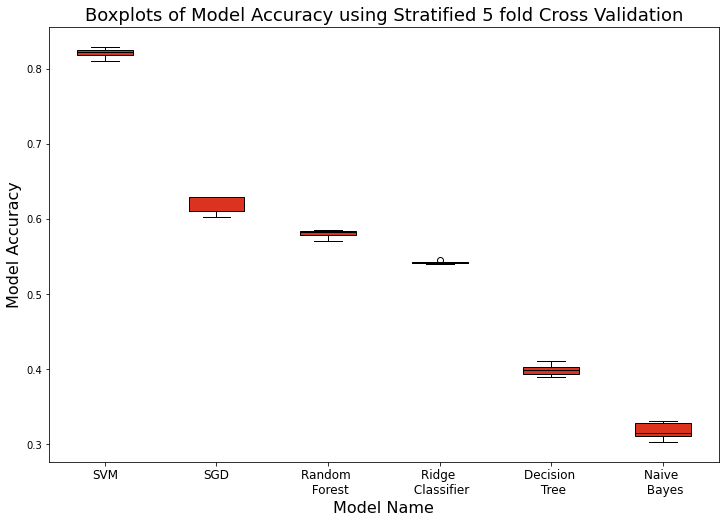

In [ ]:
#Here we plot boxplots for the classical models performance on the 5 fold cross validation
classical_boxplot_acc = plt.figure(figsize = (12,8))

medianprops = dict(color="black")
box = plt.boxplot(x = classical_model_accuracy,vert = True,patch_artist=True,medianprops= medianprops)

plt.xticks([1,2,3,4,5,6],labels  = ['SVM','SGD','Random \n Forest', 'Ridge \n Classifier','Decision \n Tree', 'Naive \n Bayes'],fontsize = 12)
plt.xlabel('Model Name',fontsize = 16)
plt.ylabel('Model Accuracy',fontsize = 16)
plt.title('Boxplots of Model Accuracy using Stratified 5 fold Cross Validation', fontsize = 18)



colors =  ['#DC3220', '#DC3220', '#DC3220','#DC3220','#DC3220', '#DC3220']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Convolutional  Neural Networks (CNNs)

In this section I will create, fit, k-fold test and evaluate various convolutional neural networks.

### CNN MODEL CREATIONS

In this subsection I define the various convolutional neural networks that I will be using to classify the images.

In [ ]:
#Model creation and layer selection for our most basic convolutional neural network consisting of a single 2D convolutional layer followed by a pooling layer
def cnn_model_1():
  x_input = layers.Input(shape=(32, 32, 1))
  x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))(x_input)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  output = layers.Dense(38, activation='softmax')(x)
  model = Model(inputs=[x_input],outputs=[output])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
#Model creation and layer selection for an extension of model_1 where an additional 2D convolutional layer followed by a pooling layer is added
def cnn_model_2():
  x_input = layers.Input(shape=(32, 32, 1))
  x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))(x_input)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1))(x)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  output = layers.Dense(38, activation='softmax')(x)
  model = Model(inputs=[x_input],outputs=[output])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
#Model creation and layer selection for an extension to model_2 where an additional 2D convolutional layer followed by a pooling layer is added
def cnn_model_3():
  x_input = layers.Input(shape=(32, 32, 1))
  x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))(x_input)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1))(x)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 1))(x)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  output = layers.Dense(38, activation='softmax')(x)
  model = Model(inputs=[x_input],outputs=[output])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
#Model creation and layer selection for an extension to model_3 where dropout is added inbetween a number of different layers to reduce overfitting.
def cnn_model_3_dropout():
  x_input = layers.Input(shape=(32, 32, 1))
  x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1))(x_input)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1))(x)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 1))(x)
  x = layers.MaxPooling2D((2, 2),strides=2)(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  output = layers.Dense(38, activation='softmax')(x)
  model = Model(inputs=[x_input],outputs=[output])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### Model Instantiation

In this subsection I instatiate the CNN models that I defined in the previous 
subsection.

In [ ]:
greek_model_1 = cnn_model_1()

In [ ]:
greek_model_2 = cnn_model_2()

In [ ]:
greek_model_3 = cnn_model_3()

In [ ]:
greek_model_4 = cnn_model_3_dropout()

### CNN Cross Validation

In this subsection I define my custom k-fold cross validation function for CNNs and I evaluate the performance of the CNNs that I created in the previous subsection. Accuracy scores on the k-fold splits are obtained on both the validation and training datasets for each model.

In [ ]:
#Function to perform 5 fold cross validation on data provided a model name and specified k fold number
def k_fold_cross_val(X_train,y_train,k,model_name):
  ''' This function performs stratified k-fold validation on convolutional neural networks provided they input an X_train,y_train array, 
  a value for number of splits for cross validation and the particular model they want to use.

  parameters:
  - X_train: Array containing training pixel data of the images
  - y_train: Array containing training labels of the images
  - k: the number of folds used in cross validation
  - model: model object

  output:
  - val_acc_scores: List containing the models k-fold cross validation accuracy scores on the validation data.
  - train_acc_scores: List containing the models k-fold cross validation accuracy scores on the training data.
  '''

  val_acc_scores = []
  train_acc_scores = []


  #Create stratified k-fold split
  k_fold_split = StratifiedKFold(n_splits=k)

  ##Iterate through the split using training data which will split further into training and validation data.
  for train_index, test_index in k_fold_split.split(X_train, y_train):
    X_train_val, X_test_val = X_train[train_index], X_train[test_index]
    y_train_val, y_test_val = y_train[train_index], y_train[test_index]


    #You are not able to stratify-k-fold split multilabel target variables so need to one-hot-encode after the stratfied split is performed.
    y_train_val = to_categorical(y_train_val,38)
    y_test_val = to_categorical(y_test_val,38)


    model = model_name()

    #Fit the model on the k-fold split. Note that if you do not want some much information about each epoch when running the 
    #cross validation then change verbose parameter to 0 rather than 2.
    model.fit(X_train_val,y_train_val,epochs=10, verbose=0, validation_data=(X_test_val, y_test_val), batch_size=32)

    #Calculate the accuracy and loss for validation data
    test_loss,test_acc = model.evaluate(X_test_val,y_test_val,verbose = 1)
    train_loss,train_acc = model.evaluate(X_train_val,y_train_val,verbose = 1)

    #Append score to list of scores
    val_acc_scores.append(test_acc)
    train_acc_scores.append(train_acc)


  return val_acc_scores, train_acc_scores

In [ ]:
#Note takes roughly around 20 minutes to run
cnn_model_1_acc, cnn_model_1_train_acc =  k_fold_cross_val(X_train_cnn_cross,y_train_cnn_cross,5,cnn_model_1)

In [ ]:
#Note takes roughly around 20 minutes to run
cnn_model_2_acc, cnn_model_2_train_acc = k_fold_cross_val(X_train_cnn_cross,y_train_cnn_cross,5,cnn_model_2)

In [ ]:
#Note takes roughly around 20 minutes to run
cnn_model_3_acc, cnn_model_3_train_acc =  k_fold_cross_val(X_train_cnn_cross,y_train_cnn_cross, 5,cnn_model_3)

In [ ]:
#Note takes roughly around 25 minutes to run
cnn_model_3_dropout_acc, cnn_model_3_dropout_train_acc=  k_fold_cross_val(X_train_cnn_cross,y_train_cnn_cross, 5, cnn_model_3_dropout)

### Comparing Classical Models and CNNs

In this subsection we breifly compare the performance of the classical classification modesls and the most basic CNN. 

In [ ]:
#Append the mean performance of CNN Model 1 to the list of mean accuracies for the classical models
classical_model_mean_accuracy.append(sum(cnn_model_1_acc)/5)

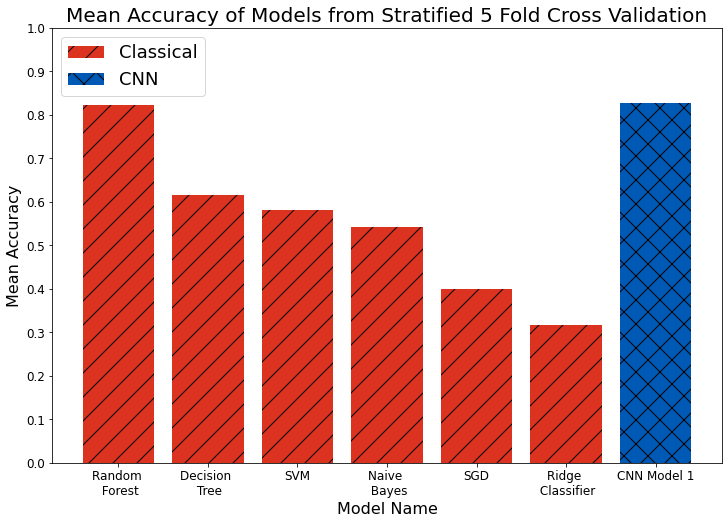

In [ ]:
#Creates a barplot of the mean accuracy score of the 5 fold-cross validation for the classical models + model 1 
model_acc_bar = plt.figure(figsize = (12,8))

bars = plt.bar([1,2,3,4,5,6,7] , classical_model_mean_accuracy,color = '#D72638' )
plt.xticks([1,2,3,4,5,6,7],labels = ['Random \n Forest', 'Decision \n Tree', 'SVM','Naive \n Bayes','SGD','Ridge \n Classifier', 'CNN Model 1'],fontsize = 12)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 12)
plt.xlabel('Model Name',fontsize = 16)
plt.ylabel('Mean Accuracy',fontsize= 16)
plt.title('Mean Accuracy of Models from Stratified 5 Fold Cross Validation',fontsize=  20)


colors = ['#DC3220', '#DC3220', '#DC3220','#DC3220','#DC3220', '#DC3220', '#005AB5']

legend_handles = [mpatches.Patch(facecolor='#DC3220',hatch = '/',label='Classical'),mpatches.Patch(facecolor='#005AB5',hatch = 'x',label='Classical')]
labels = ['Classical','CNN']
for patch, color in zip(bars, colors):
    patch.set_facecolor(color)
    patch.set_hatch('/')
  

bars[6].set_facecolor('#005AB5')
bars[6].set_hatch('x')

plt.legend(legend_handles, labels, prop={'size': 18},loc =2)

### Does the number of layers impact performance?

In this subsection we inspect how the number of layers impacts model performance using 5 fold cross validation. Recall model 1 is the most basic CNN and models 2 and 3 are extensions of model 1. Each extension involved adding more layers to the CNN, more Conv2d layers and more MaxPooling layers. I initially attempted to add even more layers to model 3 but not only did runtime increase but I didn't see an improvement in performance. 

In [ ]:
#Creates a list containing accuracy scores for cnn model 1,2 and 3 from the 5 fold cross validation
cnn_layer_acc = [cnn_model_1_acc, cnn_model_2_acc, cnn_model_3_acc]

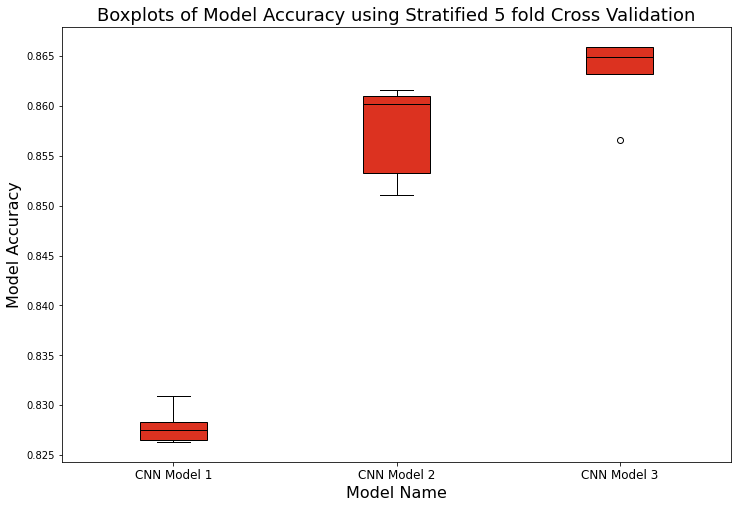

In [ ]:
# Creates a boxplot detailing the influence of the number of layers on model performance
cnn_boxplot_acc = plt.figure(figsize = (12,8))

medianprops = dict(color="black")
box = plt.boxplot(x = cnn_layer_acc,vert = True,patch_artist=True,medianprops= medianprops)

plt.xticks([1,2,3],labels = ['CNN Model 1' ,'CNN Model 2','CNN Model 3'],fontsize = 12)
plt.xlabel('Model Name',fontsize = 16)
plt.ylabel('Model Accuracy',fontsize = 16)
plt.title('Boxplots of Model Accuracy using Stratified 5 fold Cross Validation', fontsize = 18)

colors = ['#DC3220', '#DC3220', '#DC3220']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

 

### How to reduce overfitting?


In this subsection I look at how dropout reduces overfitting in a CNN. More specifically I will visualise the mean performance of the cnn model 3 with and without dropout using 5 fold cross validation.

In [ ]:
#Mean performance on training data with 5-fold cv for CNN Model 3 with and without dropout
cnn_model_3_train_mean = [sum(cnn_model_3_train_acc)/5, sum(cnn_model_3_dropout_train_acc)/5]

In [ ]:
#Mean performance on test data with 5-fold cv for CNN Model 3 with and without dropout
cnn_model_3_test_mean = [sum(cnn_model_3_acc)/5, sum(cnn_model_3_dropout_acc)/5]

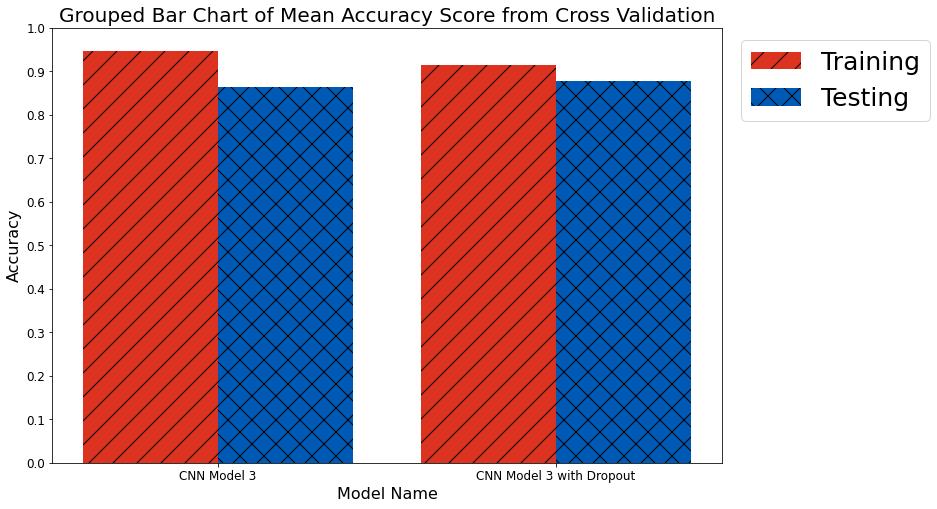

In [ ]:
#This plot creates a grouped bar chart of the cnn model 3 with and without dropout on the 5-fold split
#Notice that when dropout is used the performance on the training and test data are closer(more consistent and test performance improves)
dropout_bar_chart = plt.figure(figsize = (12,8))

x = np.arange(2) 

plt.bar(x - 0.2, cnn_model_3_train_mean, 0.4, label='Training',hatch = '/',facecolor ='#DC3220' )
plt.bar(x + 0.2, cnn_model_3_test_mean, 0.4, label='Testing',hatch = 'x',facecolor =  '#005AB5')

plt.title('Grouped Bar Chart of Mean Accuracy Score from Cross Validation',fontsize = 20)
plt.xlabel('Model Name',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 16)
plt.xticks(x, ['CNN Model 3', 'CNN Model 3 with Dropout'],fontsize = 12)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 12)
plt.legend( prop={'size': 25}, bbox_to_anchor=(1.01,1))

### Final Model Testing

In this section I will fit the final model I have chosen, the cnn model 3 with dropout, on the training dataset and evaluate its performance on the test data.

In [ ]:
#Fitting the final model on the training data
greek_model_4.fit(X_train_cnn, y_train_cnn,  epochs=20, verbose=0)

In [ ]:
#Evaluate Final model performance on test data
greek_model_4.evaluate(X_test_cnn, y_test_cnn, verbose=1)

197/197 [==============================] - 3s 14ms/step - loss: 0.3214 - accuracy: 0.9026


[0.32143643498420715, 0.9026015400886536]

### Analysing CNN performance - Classification report

In this subsection we dive deeper into evaluating the performance of the final model on the test data. This includes breaking down performance further by looking at precision,recall and f1 score for both the whole test data but also on a class by class basis.

In [ ]:
#Function takes in a model and returns the classification report for that model on the final test dataset.
def cnn_model_performance(model):
  ''' This function evaluates the performance of a model by returning its classification report.

  parameters:
  - model: model that you want to evaluate

  output:
  - classification report: Provides the accuracy, recall, f1-score for each class (each greek letter)
  '''

  #Predicts the test data
  test_predicted = model.predict(X_test_cnn)
  #Converts multilabel predicted data to single column value
  test_predicted = np.argmax(np.round(test_predicted),axis=1)
  #Converts test data to single column value
  y_test_labels = np.argmax(np.round(y_test_cnn),axis=1)

  #prints classification report to 4 decimal places
  print(classification_report(y_test_labels, test_predicted,target_names = greek_letters, digits=4))

In [ ]:
#Prints classification report for the final model.
cnn_model_performance(greek_model_4)

              precision    recall  f1-score   support

      \alpha     0.7954    0.9942    0.8838       520
       \beta     0.9777    0.9690    0.9733       226
      \gamma     0.9722    0.9211    0.9459       228
      \delta     0.9667    0.9317    0.9489       249
    \epsilon     0.9194    0.5229    0.6667       109
       \zeta     0.9660    0.8161    0.8847       174
        \eta     0.9853    0.9781    0.9817       137
      \theta     0.7917    0.8769    0.8321       130
       \iota     0.9355    0.9355    0.9355        31
      \kappa     0.8800    0.8800    0.8800        50
     \lambda     0.9747    0.9698    0.9723       199
         \mu     0.9912    0.9869    0.9891       229
         \nu     0.9221    0.9103    0.9161        78
         \xi     0.9680    0.9416    0.9546       514
         \pi     0.8006    0.8502    0.8246       307
        \rho     0.8667    0.8478    0.8571       138
      \sigma     0.9688    0.9644    0.9666       225
        \tau     0.8864    

# My Images!

I have attached an additonal workbook that will document how you can test your own models or the models shown in this workbook on your own handwritting. Please visit the My Images workbook on my GitHub repository.

# Image data with Keras (Further Work)

In this section I provide an alternative solution to loading images using keras imagedatagenerator and flow_from_dataframe. Additionally, using keras to load our images allows us to perform image augmentations to the images while the convolutional neural network is running. Due to time constraints on this project, this section is more of an experiment for learning rather than a deep look at improving the final performance of our models. With more time I would like to dive deeper into fine tuning the augmentation to hopefully improve my results.

In [ ]:
#We will be using keras flow_from_dataframe which takes a dataframe of two columns, one column with the paths to the images and the other 
# with the images label (what greek letter it is)
keras_df = greek_letters_df[['path','latex']]

In [ ]:
#Since We are working with dataframe I need to define another splitting function which is used for the final train and test split. This is not
# a splitting function for k fold validation
def keras_image_df_split(df,split):

  #Define the feature data (image pixel arrays) and the target latex
  X = df[['path']]
  y = df[['latex']]

  #Creates training and test split with test size of 0.2
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = split,random_state =32)

  return X_train,X_test,y_train,y_test

In [ ]:
X_train_aug,X_test_aug,y_train_aug,y_test_aug = keras_image_df_split(keras_df,0.2)

In [ ]:
#Creates a ImageDataGenerator - This allows us to define how we will process the images when we load in the images - In the train dataset we
#will normalise the images(divide by 255) and then augment the images by rotating, shearing and zooming randomly 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 20,
        shear_range=0.2,
        zoom_range=0.2)

In [ ]:
#On the test data we dont want to perform any augmentations so we will only normalise
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
#Since the train_datagens require dataframes and not arrays I had to create another custom k_fold_cross_validation function for augmentation.
# The input required is a dataframe containing image paths and dataframe containing image labels and k, the number of splits you want for the k fold
# cross validation

def k_fold_cross_val_data_augmentation(X_train,y_train,k):
  #Creates empty lists for storing model accuracy
  acc_scores = []

  #Define the stratified k fold splitting
  k_fold_split = StratifiedKFold(n_splits=k)


  #Iterate through the splitting for the train and test set
  for train_index, test_index in k_fold_split.split(X_train, y_train):
    #Select the relevant rows from the input dataframes
    X_train_val, X_test_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_val, y_test_val = y_train.iloc[train_index], y_train.iloc[test_index]

    #Combines the two training dataframes into one called train_df
    train_df = X_train_val.copy()
    train_df['latex'] = y_train_val

    #Combines the two validation dataframes into one called test_df
    test_df = X_test_val.copy()
    test_df['latex'] = y_test_val

    #This section was from/inspired by https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

    #Defines the train generator using the train_datagen(i.e the images we will augment)
    train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="path",
    y_col="latex",
    batch_size=32,
    seed=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32),
    color_mode="grayscale")


    #Defines the validaton generator~(i.e the test data for the k fold cross validation)
    validation_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="path",
    y_col="latex",
    batch_size=32,
    seed=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(32,32),
    color_mode="grayscale")

    #Instatiate the cnn model 3 with dropout
    model = cnn_model_3_dropout()

    #Defines the step size and fits the model using the training generator
    model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n//32,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//32,
                    epochs=10,
                    verbose = 0)
    
    #Calculates the test loss and test accuracy using the validation generator
    test_loss,test_acc = model.evaluate_generator(generator=validation_generator, steps=validation_generator.n//32)
    
    #Append test acc to the acc_score list
    acc_scores.append(test_acc)
    

  return acc_scores


In [ ]:
#Runs the 5 fold cross validation on the augmented dataset with the cnn model 3 with dropout - Note that it takes roughly 45+ minutes to run
cnn_model_3_dropout_with_aug_acc = k_fold_cross_val_data_augmentation(X_train_aug,y_train_aug,5)

In [ ]:
#To check the performance of the cnn model 3 with image augmentation I calculate the mean accruacy over the 5 fold cross validation
print('Mean accuracy: ' + str(sum(cnn_model_3_dropout_with_aug_acc)/5))

Mean accuracy: 0.858984375
